#3-1.Preprocessing

In [59]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [60]:
(train_images,train_labels),(test_images,test_labels)=mnist.load_data()
train_labels.shape

(60000,)

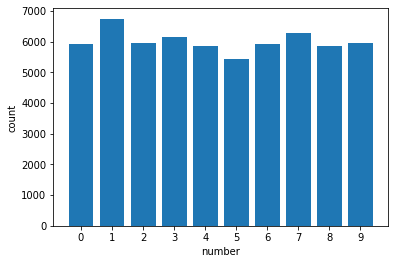

In [61]:
count=np.zeros(10)
for k in range(len(train_labels)):
  count[train_labels[k]]+=1
plt.bar(range(10),count);
plt.xticks(range(10));
plt.xlabel('number')
plt.ylabel('count');

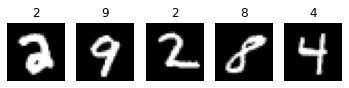

In [62]:
import random
train_num=train_images.shape[0]
fig,ax=plt.subplots(1,5)
for i in range(5):
  rand = random.randrange(train_num)
  ax[i].imshow(train_images[rand,:,:],cmap='gray')
  ax[i].title.set_text(str(train_labels[rand]))
  ax[i].axis('off')

In [63]:
#normalization
from keras.layers import Flatten
train_images=train_images.astype('float32')/255
test_images=test_images.astype('float32')/255
x_train = train_images.reshape((len(train_images), np.prod(train_images.shape[1:])))
x_test =test_images.reshape((len(test_images), np.prod(test_images.shape[1:])))

#3-2.Autoencoder

In [64]:
#structure
from keras.models import Sequential
from keras.layers import Flatten,Dense,Input
encoder=Sequential()
encoder.add(Dense(500,activation='relu',input_shape=(784,)))
encoder.add(Dense(300,activation='relu'))
encoder.add(Dense(100,activation='relu'))
encoder.add(Dense(30,activation='relu'))
encoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 500)               392500    
                                                                 
 dense_12 (Dense)            (None, 300)               150300    
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                                 
 dense_14 (Dense)            (None, 30)                3030      
                                                                 
Total params: 575,930
Trainable params: 575,930
Non-trainable params: 0
_________________________________________________________________


In [65]:
decoder=Sequential()
decoder.add(Dense(100,input_shape=(30,)))
decoder.add(Dense(300,activation='relu'))
decoder.add(Dense(500,activation='relu'))
decoder.add(Dense(784,activation='relu'))
decoder.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 100)               3100      
                                                                 
 dense_16 (Dense)            (None, 300)               30300     
                                                                 
 dense_17 (Dense)            (None, 500)               150500    
                                                                 
 dense_18 (Dense)            (None, 784)               392784    
                                                                 
Total params: 576,684
Trainable params: 576,684
Non-trainable params: 0
_________________________________________________________________


In [66]:
import tensorflow as tf
x = Input(shape = (784,))
latent=encoder(x)
output=decoder(latent)
autoencoder=tf.keras.Model(inputs=x,outputs=output)

In [67]:
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
,loss=tf.keras.losses.MSE)

In [68]:
(x_train,x_val)=x_train[:48000],x_train[48000:]
(train_labels,val_labels)=train_labels[:48000],train_labels[48000:]
callback=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    mode="min",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10,
)
hist=autoencoder.fit(x_train,x_train,batch_size=128,epochs=100 ,validation_data=(x_val,x_val),callbacks=[callback])

Epoch 1/100
375/375 [==============================] - 8s 8ms/step - loss: 0.0294 - val_loss: 0.0178
Epoch 2/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0156 - val_loss: 0.0140
Epoch 3/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0132 - val_loss: 0.0126
Epoch 4/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0121 - val_loss: 0.0120
Epoch 5/100
375/375 [==============================] - 3s 9ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 6/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 7/100
375/375 [==============================] - 2s 7ms/step - loss: 0.0106 - val_loss: 0.0108
Epoch 8/100
375/375 [==============================] - 3s 7ms/step - loss: 0.0103 - val_loss: 0.0106
Epoch 9/100
375/375 [==============================] - 3s 8ms/step - loss: 0.0100 - val_loss: 0.0102
Epoch 10/100
375/375 [==============================] - 3s 9ms/step - loss: 0.0098 - val_lo

Text(0.5, 0, 'epochs')

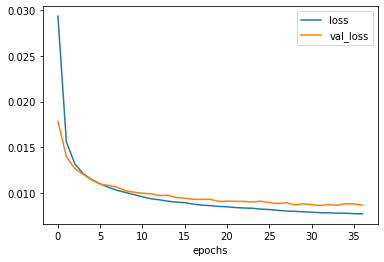

In [69]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('epochs')

#3-3.Classification

In [70]:
train_latent=encoder.predict(x_train)

1500/1500 [==============================] - 2s 1ms/step


In [71]:
val_latent=encoder.predict(x_val)

375/375 [==============================] - 1s 1ms/step


In [72]:
test_latent=encoder.predict(x_test)

313/313 [==============================] - 1s 1ms/step


In [73]:
from keras.utils import to_categorical
numclass=10;
y_train=to_categorical(train_labels,numclass)
y_test=to_categorical(test_labels,numclass)
y_val=to_categorical(val_labels,numclass)

In [74]:
classifier=Sequential()
classifier.add(Dense(20,input_shape=(30,),activation='relu'))
classifier.add(Dense(15,activation='relu'))
classifier.add(Dense(10,activation='softmax'))
classifier.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 20)                620       
                                                                 
 dense_20 (Dense)            (None, 15)                315       
                                                                 
 dense_21 (Dense)            (None, 10)                160       
                                                                 
Total params: 1,095
Trainable params: 1,095
Non-trainable params: 0
_________________________________________________________________


In [75]:
classifier.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
,loss='categorical_crossentropy',metrics=['accuracy'])

In [76]:
callback2=tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=10,
)
classHist=classifier.fit(train_latent,y_train,epochs=100 ,validation_data=(val_latent,y_val),callbacks=[callback2])

Epoch 1/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.8882 - accuracy: 0.7321 - val_loss: 0.4127 - val_accuracy: 0.8838
Epoch 2/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.4113 - accuracy: 0.8757 - val_loss: 0.3561 - val_accuracy: 0.8959
Epoch 3/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3639 - accuracy: 0.8894 - val_loss: 0.3152 - val_accuracy: 0.9078
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3370 - accuracy: 0.8980 - val_loss: 0.3026 - val_accuracy: 0.9128
Epoch 5/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.3176 - accuracy: 0.9040 - val_loss: 0.2796 - val_accuracy: 0.9174
Epoch 6/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2997 - accuracy: 0.9094 - val_loss: 0.2694 - val_accuracy: 0.9196
Epoch 7/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2882 - accuracy: 0.9128 - val_loss: 0.2724 - val_ac

Text(0.5, 0, 'epochs')

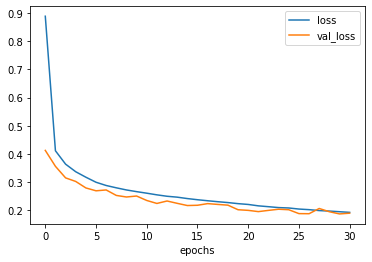

In [77]:
plt.plot(classHist.history['loss'])
plt.plot(classHist.history['val_loss'])
plt.legend(['loss','val_loss'])
plt.xlabel('epochs')

Text(0.5, 0, 'epochs')

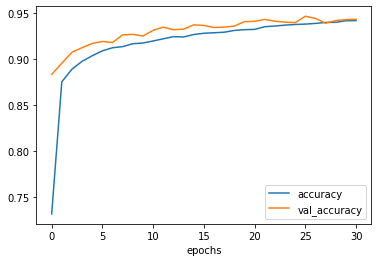

In [78]:
plt.plot(classHist.history['accuracy'])
plt.plot(classHist.history['val_accuracy'])
plt.legend(['accuracy','val_accuracy'])
plt.xlabel('epochs')

In [79]:
classifier.evaluate(test_latent,y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1866 - accuracy: 0.9468


[0.18657900393009186, 0.9467999935150146]

In [80]:
y_predict = classifier.predict(test_latent)

313/313 [==============================] - 1s 1ms/step


In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [82]:
y_predict.argmax(axis =1)

array([7, 2, 1, ..., 4, 5, 6])

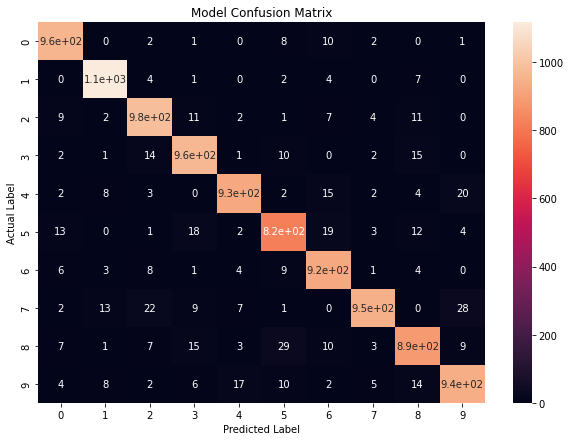

In [86]:
model_cm = confusion_matrix(y_test.argmax(axis =1), y_predict.argmax(axis =1))
plt.figure(figsize = (10,7))
sns.heatmap(model_cm, annot=True)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Model Confusion Matrix');